# Automatic Feature Selection

Adding new features to the dataset can lead our ML algorithm to overfitting. Therefore, it can be a good idea to reduce the number of features for high-dimensional datasets. You know what they say: "Simpler models generalize better".

The question is: "How to measure how good a feature is?". Here I'll explore three *supervised* strategies to tackle this question. The strategies are:
    
    (1) Univariate statistics
    (2) Model-based selection
    (3) Iterative selecion


# Univariate Statistics

Here we are interested in measuring the statistical significance of the relationship between each feature and the target. In classification tasks it's called *analysis of variance* (ANOVA).

Univariate statistics considers only one feature each time. Therefore, we can discard features that are not relevant isolated but are informative when combined with another feature. Also, univariate statistics are completely independent of the model we want to apply and pretty fast to compute.

All univariate methods use a *threshold* to discard all features with too high (unlikely related to the target) a *p*-value.

## Application of Univariate Statistics (SelectPercentile [threshold is a percentile])

We'll use the Breast Cancer dataset and add 50 new random features to the dataset. The method is expected to remove these features. 

In [21]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))

# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
 X_w_noise, cancer.target, random_state=0, test_size=.5)

# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


We used SelectPercentile to remove half of features of the dataset. It uses ANOVA F-value (you can select another method) to measure how much a feature is related to the target. The method removed all 40 random features. Below are the selected featuers.

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


Text(0.5, 0, 'Sample index')

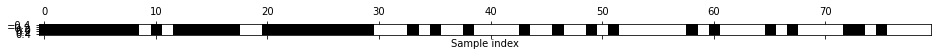

In [22]:
import matplotlib.pyplot as plt

mask = select.get_support()
print(mask)

# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index");

Next, we transform the test data, so we can use a ML algo. to predict the classes.

In [24]:
from sklearn.linear_model import LogisticRegression

# transform test data
X_test_selected = select.transform(X_test)

lr = LogisticRegression(solver='liblinear')

lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))

lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(lr.score(X_test_selected, y_test)))

Score with all features: 0.930
Score with only selected features: 0.940


The results are better with only selected features.

# Model-Based Feature Selection

This method of feature selection uses a supervised machine learning model to judge the importance of each feature.
There are ML algo (e.g. Decision tree-based models, linear models, etc) that naturally attach importance to features.
It is important to mention that we do not need to use the same ML algo that we used for feature selection. Model-based selection considers all features at once, an so capture interactions.

Below is an example of using RandomForestClassifier for Feature Selection.

In [30]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="median")
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


And here is the features that the model selected.

Text(0.5, 0, 'Sample index')

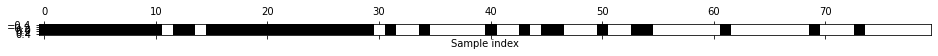

In [27]:
mask = select.get_support()

# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index");

In [31]:
X_test_l1 = select.transform(X_test)

score = LogisticRegression(solver='liblinear').fit(X_train_l1, y_train).score(X_test_l1, y_test)

print("Test score: {:.3f}".format(score))

Test score: 0.951


The model-based feature selection costs more, but also produces better results.

# Iterative Feature Selection

(a) Univariate statistics: No model.
(b) Model-based selection: A single model.
(c) Iterative feature selection: Multiple models.

In Iterative Feature selection, we build a serie of models with varying number of features.
Hence, we construct the set of features using a top-down or bottom-up appproach.

The method known as *recursive feature elimination* (RFE) folows a top-down approch, in other words, we begin with all features, builds a model, and discards the least important feature according to the model. Then the next model is used to select more feature until a prespecified number of features are left.

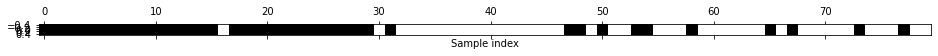

In [33]:
from sklearn.feature_selection import RFE

select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40)
select.fit(X_train, y_train)

# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index");

Here is the LR's results with RFE.

In [38]:
X_train_rfe= select.transform(X_train)
X_test_rfe= select.transform(X_test)

score = LogisticRegression(solver='liblinear').fit(X_train_rfe, y_train).score(X_test_rfe, y_test)

print("Test score: {:.3f}".format(score))

Test score: 0.951


We can also use the RFE to make predictions.

In [39]:
print("Test score: {:.3f}".format(select.score(X_test, y_test)))

Test score: 0.951


In real life application, feature selection is unlikely to provide large gains in performance, but it's still a valuable tool. Selecting useful features can speed up predictions and make our models more interpretable.